#### 딥러닝 프레임웍 로드

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

tf.__version__

'2.15.0'

In [ ]:
# 백엔드 엔진 확인
# 백엔드가 교체되면 성능등 방식이 달라질수 있음
keras.backend.backend()

'tensorflow'

# 데이터 수집/획득

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
# 데이터획득, 훈련용, 테스트용으로 자동분류
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# (60000, 28, 28), (60000,)
# (10000, 28, 28), (10000,)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
type(X_train)

numpy.ndarray

# 데이터 준비

In [ ]:
# 데이터 확인
# 데이터는 배열, 값 -> 픽셀 -> 피처로 인식
# 0 ~ 255값으로 예측, QnA : df로 구성해서 확인가능, min(), max() 확인가능함
X_train[ :1, :1, :]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]]], dtype=uint8)

In [ ]:
# 포멧 확인 -> channel first|last
fmt = keras.backend.image_data_format()
# channels_last => (N, H, W, C) 형태로 데이터 구성
fmt

'channels_last'

In [ ]:
# 필요시 정규화 진행 -> 0.0 ~ 1.0 사이로 값변환
import numpy as np

np.min(X_train), np.max(X_train)

(0, 255)

In [ ]:
# X_train, X_test 0.0 ~ 1.0 사이 조정
# 실습 30초
X_train = X_train/ np.max(X_train)
X_test  = X_test / np.max(X_test)

np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0.0, 1.0, 0.0, 1.0)

# 데이터 분석(생략)

# 모델 구축(딥러닝)

## 훈련/학습에 필요한 상수 정의

In [ ]:
# 비정형데이터(이미지) => 필요한 상수
_, PIXEL_H, PIXEL_W = X_train.shape # 높이, 너비 값 획득
# 총픽셀수 -> 총피처수
PIXELS = PIXEL_H * PIXEL_W
# 정답의 개수
LABEL_NUM = len(np.unique( y_train))
# 원본이미지의 채널수 (grayscale)
INPUT_CHANNEL = 1

PIXEL_H, PIXEL_W, PIXELS, LABEL_NUM, INPUT_CHANNEL

(28, 28, 784, 10, 1)

## 엔진별 지원 포멧에 맞게 데이터 조정(shape 조정)

In [ ]:
# fmt 값에 의해서 X_train, X_test shape을 조정하시오
# 실습 3분
if fmt == 'channels_last': # NHWC
    X_train = X_train.reshape(-1, PIXEL_H, PIXEL_W, INPUT_CHANNEL)
    X_test  = X_test.reshape(-1, PIXEL_H, PIXEL_W, INPUT_CHANNEL)
    # 최초 합성곱층에서 입력층을 직접 연결할대 shape값 (높이, 너비, 채널수)
    input_shape = (PIXEL_H, PIXEL_W, INPUT_CHANNEL)
else: # NCHW
    X_train = X_train.reshape(-1, INPUT_CHANNEL, PIXEL_H, PIXEL_W)
    X_test  = X_test.reshape(-1, INPUT_CHANNEL, PIXEL_H, PIXEL_W)
    input_shape = (INPUT_CHANNEL, PIXEL_H, PIXEL_W)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

- 픽셀값 : 0.0 ~ 1.0
- shape 형태 조정 완료

## 정답 데이터 조정

In [ ]:
# 0 ~ 9
# 머신러닝 관점에서는 이웃한 데이터를 더 가깝게 느낀다 -> 단순히 기호를 분류를해는 과정 -> 원-핫처리
np.unique( y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
y_train = keras.utils.to_categorical( y_train, LABEL_NUM )
y_test  = keras.utils.to_categorical( y_test, LABEL_NUM )

# 공간을 더 차지하지만, 학습적 이득이 더 많다

In [ ]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

## 인공신경망 구축 (CNN 기반)

```
- 입력층
- 은닉층
    - 합성곱층 1f : 1채널 -> 32채널확장(설정값), 패딩옵션 same -> 크기 28로 유지
    - 풀링층 1f : 이미지 크기를 절반 축소(28->14), 스트라이드 2, 패딩 same
    - 드롭아웃층
    - 합성곱층 2f : 32채널 -> 64채널확장(설정값), 패딩옵션 same -> 크기 14로 유지
    - 풀링층 2f : 이미지 크기를 절반 축소(14->7), 스트라이드 2, 패딩 same
    - 드롭아웃층
    - 전결합층 : 4D -> 2D로 조정, 피처수를 1024로 수렴( 설정값) : 7*7*64 -> 1024
    - 드롭아웃층
- 출력층 : 1024 -> 10 개로 수렴
```

```
shape 설계, 층 설계

- input
    (None, 28, 28, 1)
- conv 1f
    (None, 28, 28, 32)
- pool 1f max
    (None, 14, 14, 32)
- conv 2f
    (None, 14, 14, 64)
- pool 2f max
    (None, 7, 7, 64)
- flattern
    (None, 7 * 7 * 64)
- fully connected layer
    (None, 1024)
- output
    (None, 10)
```

In [ ]:
from tensorflow.keras import models, layers

In [ ]:
model = models.Sequential()

In [ ]:
# 합성곱층
'''
- filters                       # 출력 채널수를 지정, 원본이미지가 합성곱을 통과할때
                                # 출력 채널수만큼 데이터가 증가
                                # 설정값 32
- kernel_size                   # 커널(필터)가 원본 이미지상을 이동하면서 공간정보 추출
                                # 원본이미지상에 얼마나 겹쳐서 추출 => 크기 필요, 정방행렬
                                # 설정값 (5,5)
- strides=(1, 1)                # 커널이 원본이미지를 슬라이딩하면 이동할대 이동량 (좌우,상하)
                                # 통상 동일값 부여
                                # 기본값 (1,1)
- padding='valid'               # 커널이 이미지의 경계선에 도달할때 이동량, 크기 때문에 진입
                                # 않되는 경우 보정
                                # 설정값 : same, 원본과 동일하게 구성하는것을 목표
- data_format=None,             # 'channel_last',...
- activation=None,              # 활성화 함수, relu(0보다 작으면 0, 양수면 원래값그대로 사용)설정
- use_bias=True,                # 편향 사용, 기본값 유지
- ...
- **kwargs                      # 업그레이드용, 추가 파라미터용도
'''
model.add( layers.Conv2D(
    filters     = 32,
    kernel_size = (5,5),
    strides     = (1, 1),
    padding     = 'same',
    activation  = 'relu', # 가중치*원본이미지(커널사이즈) => 행렬곱
                          # => 음수가 나올수도 있음 => 음수=>0으로처리, 양수는 원래값
    use_bias    = True,
    input_shape = input_shape   # input_shape을 사용, 입력층 연결의 흔적, 첫번째 conv에서만 등장
))
# 내부적으로는 y = Wx + b를 기반으로 연결한다 -> low level 적

In [ ]:
# 풀링층(최대)
'''
- pool_size=(2, 2)  # 커널의 크기 -> 원봄상에 커널을 위치시켜서
                    # 해당위치와 겹치는 데이터만대상 -> 최대값 추출
- strides=None      # 커널의 이동량, None이면 커널크기와동일, 2칸식이동
- padding='valid'   # 합성곱과 동일
'''
model.add( layers.MaxPool2D(
    pool_size   = (2,2),
    strides     = None,
    padding     = 'same' # 28 -> 14
) )

In [ ]:
model.add( layers.Dropout(0.1) ) # 드롭아웃
# 실습 1분 합성곱층, 최대풀링층 2f 구성
model.add( layers.Conv2D(64, (5,5), padding='same', activation='relu') ) # 합성곱층
model.add( layers.MaxPool2D(padding = 'same') ) # 최대풀링층 17->7
model.add( layers.Dropout(0.1) )    # 드롭아웃 => 0.1
model.add( layers.Flatten() )       # flattern() 4D->2D
model.add( layers.Dense( 1024, activation='relu') ) # 전결합층
model.add( layers.Dropout(0.1) ) # 드롭아웃
model.add( layers.Dense( LABEL_NUM, activation='softmax')) # 출력층, 10개로 수렴

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)         

- 파라미터 계산

```
    - 파라미터 832를 도출하시오(계산식) 실습 1분
    - 파라미터는 w(가중치가 매개변수로가지고 있음), b
    - 832 = (5 x 5) X 32 + 32
    - QnA
    - 51264 =
    - 3212288 =
    - 10250 =
    
```

In [ ]:
5 * 5 * 32 + 32

832

## 학습에 필요한 컴파일 환경 세팅

In [ ]:
model.compile(optimizer='adam',
              loss     = keras.losses.categorical_crossentropy,
              metrics  =['accuracy'])

## 학습 (미니배치학습)

In [ ]:
# 학습에 필요한 상수, 변수 지정
EPOCH  = 10 # 전체 데이터 10회 풀로 반복
BATCH_SIZE = 128 # 1회 학습시 사용되는 학습량 -> 조정가능
IS_GPU = True # False

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
def train():

    cus_callbacks = [
        # 조기학습 종료
        # 조기학습종료이벤트가 발동 => 2회 더 진행 => 변화없으면 종료
        EarlyStopping( patience=2 ),
        # 모델 저장(성능이 개선될때 진행)
        ModelCheckpoint( filepath='model.{epoch}-{val_loss:2f}.h5'),
        # 시각화용 텐서보드용 로그 저장 (구글 드라이브 특정위치 권장)
        TensorBoard(log_dir='./logs')
    ]
    # 학습 로그 출력
    return model.fit(X_train, y_train,
              batch_size=BATCH_SIZE, epochs=EPOCH,
              callbacks=cus_callbacks, validation_split=0.2 #조기학습종료, 20%를 검증용 사용
              )
    pass

In [ ]:
%%time
if IS_GPU:
    with tf.device('/device:GPU:0'): # 1대만 존재, 여러대중 한대만 사용하는 경우
        history = train()
else: # cpu
    print( 'cpu 실행' )
    history = train()

Epoch 1/10
375/375 [==============================] - 5s 9ms/step - loss: 0.1671 - accuracy: 0.9474 - val_loss: 0.0522 - val_accuracy: 0.9852
Epoch 2/10
 17/375 [>.............................] - ETA: 2s - loss: 0.0462 - accuracy: 0.9867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 3s 8ms/step - loss: 0.0481 - accuracy: 0.9854 - val_loss: 0.0390 - val_accuracy: 0.9884
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0331 - accuracy: 0.9897 - val_loss: 0.0360 - val_accuracy: 0.9883
Epoch 4/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0251 - accuracy: 0.9919 - val_loss: 0.0347 - val_accuracy: 0.9900
Epoch 5/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0190 - accuracy: 0.9935 - val_loss: 0.0357 - val_accuracy: 0.9903
Epoch 6/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.0331 - val_accuracy: 0.9908
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0140 - accuracy: 0.9954 - val_loss: 0.0343 - val_accuracy: 0.9913
Epoch 8/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0120 - accuracy: 0.9958 - val_loss: 0.0377 - val_accuracy: 0.9893
CPU times: user

In [ ]:
# 현재 GPU 대비 CPU의 학습 시간 속도 비율 -> 71배 (일반적이지는 않지만 더 빨리 마무리된다)
(150*10)/(3*7)

71.42857142857143

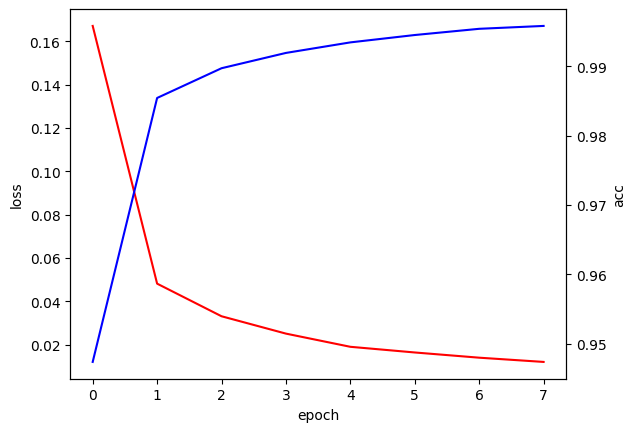

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()

acc_ax = ax.twinx()

# 손실
ax.plot(     history.history['loss'], 'r', label='loss')
# 정확도
acc_ax.plot( history.history['accuracy'], 'b', label='acc')

# 축이름
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')

plt.show()

# 인공신경망 구성은 데이터에 적합하게 구성 -> 학습 -> 결과가 잘 나옴

## 테스트 데이터를 이용한 예측

In [ ]:
model.evaluate( X_test, y_test )

313/313 [==============================] - 1s 3ms/step - loss: 0.0367 - accuracy: 0.9888


[0.03667498007416725, 0.9887999892234802]

# 시스템구축(사용라이브러리,모델덤프)

## 모델 저장(덤프), 로드, 테스팅

In [ ]:
# 저장
model.save('mnist_clf_keras.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 로드
# 테스트용, 실제 서비스용(웹, 앱), 특정데이터를 분석용도 -> 데이터를 구축(피처 제작용도)
# 텐서플로우 버전 일치(중요)
loaded_model = models.load_model('mnist_clf_keras.h5')

- 위에서 학습한 모델 => 사전학습된 모델로 간주
- 차후 추가 학습시
    - 기존 모델을 저장한 파일
    - 로드
    - 로드된 모델.fit() -> 학습 성능을향상 -> 저장

In [ ]:
loaded_model.evaluate( X_test, y_test )

# 토치모델->텐서모델 마이그레이션 => 정보손실일부 발생할수 있음(가중치 손실)
# 저장된모델:[0.03667498007416725, 0.9887999892234802]
# 로드한모델:[0.03667498007416725, 0.9887999892234802]

313/313 [==============================] - 1s 3ms/step - loss: 0.0367 - accuracy: 0.9888


[0.03667498007416725, 0.9887999892234802]

## 모델 정보 시각화

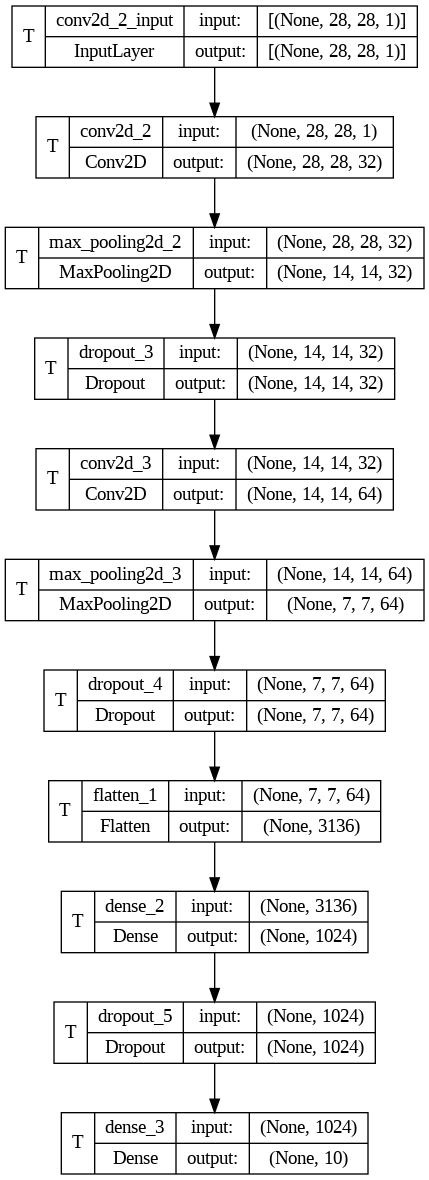

In [ ]:
# 인공신경망 요약표 => 시각적 확인
keras.utils.plot_model(loaded_model, to_file='model.png', show_shapes=True,
                       show_layer_names=True, show_trainable=True)
# 훈련가능여부, 레이어 이름, 레이어당 입력shape/출력shape 확인

## 가중치만 저장

In [ ]:
model.save_weights('mnist_clf_keras.weight')